In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

In [3]:
cwd = os.getcwd()

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/Development_Dataset.zip

Archive:  /content/drive/MyDrive/Development_Dataset.zip
replace Development_Dataset/LICENSE.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Development_Dataset/LICENSE.txt  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02841.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images

In [6]:
cd drive/MyDrive

/content/drive/MyDrive


# Example: Image Segmentation
## Build segmentation

In [7]:
import sys
sys.path.append('/content/drive/MyDrive/starting_kit')


In [8]:
import read_mask_example as rme
import prepare_submission as ps
import shutil
import random
import json
import math

SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.path.join(os.path.dirname(os.getcwd()),"Development_Dataset")

test_dir = {}
dataset_dir = {}

dataset_dir[0] = os.path.join(cwd,'Training/Bipbip/Mais')
dataset_dir[1] = os.path.join(cwd,'Training/Bipbip/Haricot')

test_dir[0] = os.path.join(cwd,'Test_Dev/Bipbip/Mais')
test_dir[1] = os.path.join(cwd,'Test_Dev/Bipbip/Haricot')
test_dir[2] = os.path.join(cwd,'Test_Dev/Pead/Mais')
test_dir[3] = os.path.join(cwd,'Test_Dev/Pead/Haricot')
test_dir[4] = os.path.join(cwd,'Test_Dev/Roseau/Mais')
test_dir[5] = os.path.join(cwd,'Test_Dev/Roseau/Haricot')
test_dir[6] = os.path.join(cwd,'Test_Dev/Weedelec/Mais')
test_dir[7] = os.path.join(cwd,'Test_Dev/Weedelec/Haricot')

crops = {}

crops[0] = "Mais"
crops[1] = "Haricot"

teams = {}

teams[0] = "Bipbip"
teams[1] = "Pead"
teams[2] = "Roseau"
teams[3] = "Weedelec"


In [9]:
print(dataset_dir)
print(test_dir)

{0: '/content/drive/Development_Dataset/Training/Bipbip/Mais', 1: '/content/drive/Development_Dataset/Training/Bipbip/Haricot'}
{0: '/content/drive/Development_Dataset/Test_Dev/Bipbip/Mais', 1: '/content/drive/Development_Dataset/Test_Dev/Bipbip/Haricot', 2: '/content/drive/Development_Dataset/Test_Dev/Pead/Mais', 3: '/content/drive/Development_Dataset/Test_Dev/Pead/Haricot', 4: '/content/drive/Development_Dataset/Test_Dev/Roseau/Mais', 5: '/content/drive/Development_Dataset/Test_Dev/Roseau/Haricot', 6: '/content/drive/Development_Dataset/Test_Dev/Weedelec/Mais', 7: '/content/drive/Development_Dataset/Test_Dev/Weedelec/Haricot'}


In [10]:
dataset_dir = {0: '/content/Development_Dataset/Training/Bipbip/Mais', 1: '/content/Development_Dataset/Training/Bipbip/Haricot'}
test_dir = {0: '/content/Development_Dataset/Test_Dev/Bipbip/Mais', 1: '/content/Development_Dataset/Test_Dev/Bipbip/Haricot', 2: '/content/Development_Dataset/Test_Dev/Pead/Mais', 3: '/content/Development_Dataset/Test_Dev/Pead/Haricot', 4: '/content/Development_Dataset/Test_Dev/Roseau/Mais', 5: '/content/Development_Dataset/Test_Dev/Roseau/Haricot', 6: '/content/Development_Dataset/Test_Dev/Weedelec/Mais', 7: '/content/Development_Dataset/Test_Dev/Weedelec/Haricot'}


In [11]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [12]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

    """
        CustomDataset inheriting from tf.keras.utils.Sequence.

        3 main methods:
          - __init__: save dataset params like directory, filenames..
          - __len__: return the total number of samples in the dataset
          - __getitem__: return a sample from the dataset

        Note: 
          - the custom dataset return a single sample from the dataset. Then, we use 
            a tf.data.Dataset object to group samples into batches.
          - in this case we have a different structure of the dataset in memory. 
            We have all the images in the same folder and the training and validation splits
            are defined in text files.

      """

    def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
                preprocessing_function=None, out_shape=[256, 256]):
        if which_subset == 'training':
            subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
        elif which_subset == 'validation':
            subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
        with open(subset_file, 'r') as f:
            lines = f.readlines()
    
        subset_filenames = []
        for line in lines:
            subset_filenames.append(line.strip()) 

        self.which_subset = which_subset
        self.dataset_dir = dataset_dir
        self.subset_filenames = subset_filenames
        self.img_generator = img_generator
        self.mask_generator = mask_generator
        self.preprocessing_function = preprocessing_function
        self.out_shape = out_shape

    def __len__(self):
        return len(self.subset_filenames)

    def __getitem__(self, index):
        # Read Image
        curr_filename = self.subset_filenames[index]
        img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename + '.jpg'))
        #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

        # Resize image and mask
        img = img.resize(self.out_shape)
        

        
       # mask = mask.resize(self.out_shape)
    
        img_arr = np.array(img)
        mask_arr = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'),self.out_shape)#WHAT NEEDS TO BE CHANGED
        #print(mask_arr.shape)
        
        # in this dataset 255 mask label is assigned to an additional class, which corresponds 
        # to the contours of the objects. We remove it for simplicity.
        mask_arr[mask_arr == 255] = 0  

        mask_arr = np.expand_dims(mask_arr, -1)

        if self.which_subset == 'training':
            if self.img_generator is not None and self.mask_generator is not None:
                # Perform data augmentation
                # We can get a random transformation from the ImageDataGenerator using get_random_transform
                # and we can apply it to the image using apply_transform
                img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
                mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
                img_arr = self.img_generator.apply_transform(img_arr, img_t)
                # ImageDataGenerator use bilinear interpolation for augmenting the images.
                # Thus, when applied to the masks it will output 'interpolated classes', which
                # is an unwanted behaviour. As a trick, we can transform each class mask 
                # separately and then we can cast to integer values (as in the binary segmentation notebook).
                # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
                out_mask = np.zeros_like(mask_arr)
                for c in np.unique(mask_arr):
                    if c > 0:
                        curr_class_arr = np.float32(mask_arr == c)
                        curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
                        # from [0, 1] to {0, 1}
                        curr_class_arr = np.uint8(curr_class_arr)
                        # recover original class
                        curr_class_arr = curr_class_arr * c 
                        out_mask += curr_class_arr
        else:
            out_mask = mask_arr
    
        if self.preprocessing_function is not None:
            img_arr = self.preprocessing_function(img_arr)
        
        return img_arr, np.float32(out_mask)

In [13]:
for j in range (0,2):
    if not os.path.exists(os.path.join(dataset_dir[j],"Splits/")):
        os.makedirs(os.path.join(dataset_dir[j],"Splits/"))

    image_filenames = next(os.walk(os.path.join(dataset_dir[j],"Images/")))[2]
    
    val=[]
    train=[]
    
    for image_name in image_filenames:
        if 100*random.random() < 10:
            val.append(image_name[:-4])
        else:
            train.append(image_name[:-4])
    
    with open(os.path.join(dataset_dir[j],"Splits","train.txt"), 'w') as file:  # Use file to refer to the file object
        for i in train:
            file.write(str(i)+"\n")
    
    with open(os.path.join(dataset_dir[j],"Splits","val.txt"), 'w') as file:  # Use file to refer to the file object
        for i in val:
            file.write(str(i)+"\n")

   

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

21

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

24

In [14]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 1536
img_w = 2048

dataset = CustomDataset(dataset_dir[0], 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input, out_shape=[img_w,img_h])

dataset1 = CustomDataset(dataset_dir[1], 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input, out_shape=[img_w,img_h])

dataset_valid = CustomDataset(dataset_dir[0], 'validation', 
                              preprocessing_function=preprocess_input,out_shape=[img_w,img_h])

dataset_valid1 = CustomDataset(dataset_dir[1], 'validation', 
                              preprocessing_function=preprocess_input,out_shape=[img_w,img_h])


In [15]:

train_dataset0 = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset1 = tf.data.Dataset.from_generator(lambda: dataset1,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset0.concatenate(train_dataset1)

train_dataset = train_dataset.batch(1)

train_dataset = train_dataset.repeat()

valid_dataset0 = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset1 = tf.data.Dataset.from_generator(lambda: dataset_valid1,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

valid_dataset = valid_dataset0.concatenate(valid_dataset1)

valid_dataset = valid_dataset.batch(1)

valid_dataset = valid_dataset.repeat()

In [16]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0. 1. 2.]


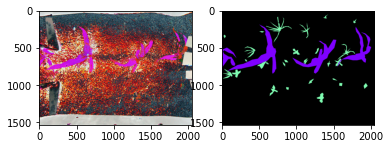

In [17]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
vgg.summary()
for layer in vgg.layers:
  layer.trainable = False

In [18]:
def create_model(depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    model.add(vgg)
    
    start_f = 256
        
    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model

In [19]:
#model = create_model(depth=5, 
#                     start_f=8, 
#                     num_classes=3)

# Visualize created model as a table

def get_crop_shape(target, refer):
        # width, the 3rd dimension
        cw = (target.get_shape()[2] - refer.get_shape()[2])
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        # height, the 2nd dimension
        ch = (target.get_shape()[1] - refer.get_shape()[1])
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)

        return (ch1, ch2), (cw1, cw2)


concat_axis = 3
inputs = tf.keras.layers.Input(shape = [img_h,img_w,3])

conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up_conv5 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv5)
ch, cw = get_crop_shape(conv4, up_conv5)
crop_conv4 = tf.keras.layers.Cropping2D(cropping=(ch,cw))(conv4)
up6 = tf.keras.layers.concatenate([up_conv5, crop_conv4], axis=concat_axis)
conv6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up_conv6 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv6)
ch, cw = get_crop_shape(conv3, up_conv6)
crop_conv3 = tf.keras.layers.Cropping2D(cropping=(ch,cw))(conv3)
up7 = tf.keras.layers.concatenate([up_conv6, crop_conv3], axis=concat_axis) 
conv7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up_conv7 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv7)
ch, cw = get_crop_shape(conv2, up_conv7)
crop_conv2 = tf.keras.layers.Cropping2D(cropping=(ch,cw))(conv2)
up8 = tf.keras.layers.concatenate([up_conv7, crop_conv2], axis=concat_axis)
conv8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up_conv8 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv8)
ch, cw = get_crop_shape(conv1, up_conv8)
crop_conv1 = tf.keras.layers.Cropping2D(cropping=(ch,cw))(conv1)
up9 = tf.keras.layers.concatenate([up_conv8, crop_conv1], axis=concat_axis)
conv9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

ch, cw = get_crop_shape(inputs, conv9)
conv9 = tf.keras.layers.ZeroPadding2D(padding=((ch[0], ch[1]), (cw[0], cw[1])))(conv9)
conv10 = tf.keras.layers.Conv2D(3, (1, 1))(conv9)

model = tf.keras.models.Model(inputs=inputs, outputs=conv10)

# Visualize created model as a table
model.summary()

# Visualize initialized weights
# model.weights



model.summary()

# Visualize initialized weights
# model.weights

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1536, 2048,  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 1536, 2048, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1536, 2048, 3 9248        conv1_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 768, 1024, 32 0           conv2d[0][0]                     
_______________________________________________________________________________________

In [20]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
import os
from datetime import datetime

cwd1 = os.getcwd()

exps_dir = os.path.join(cwd1, 'multiclass_exps')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_meanIoU', patience=10, mode="max")
    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset)+len(dataset1),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid)+len(dataset_valid1), 
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/100
162/162 [==============================] - 407s 3s/step - loss: 0.4278 - accuracy: 0.9128 - meanIoU: 0.1928 - val_loss: 0.3652 - val_accuracy: 0.8659 - val_meanIoU: 0.1795
Epoch 2/100
162/162 [==============================] - 399s 2s/step - loss: 0.2687 - accuracy: 0.9307 - meanIoU: 0.2768 - val_loss: 0.3244 - val_accuracy: 0.8785 - val_meanIoU: 0.2192
Epoch 3/100
162/162 [==============================] - 395s 2s/step - loss: 0.2744 - accuracy: 0.9047 - meanIoU: 0.1131 - val_loss: 0.3258 - val_accuracy: 0.8549 - val_meanIoU: 0.1515
Epoch 4/100
162/162 [==============================] - 387s 2s/step - loss: 1.0577 - accuracy: 0.0823 - meanIoU: 0.0265 - val_loss: 1.0986 - val_accuracy: 0.0693 - val_meanIoU: 0.0345
Epoch 5/100
162/162 [==============================] - 386s 2s/step - loss: 1.0986 - accuracy: 0.0393 - meanIoU: 0.0203 - val_loss: 1.0986 - val_accuracy: 0.0693 - val_meanIoU: 0.0345
Epoch 6/100
162/162 [==============================] - 388s 2s/step - loss: 1.09

import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

In [ ]:
submission_dict = {} 

for i in range(0,8):
    image_filenames = next(os.walk(os.path.join(test_dir[i],"Images/")))[2]

    if i in range(4,6):
        suffix = ".png"
    else:
        suffix = ".jpg"
    
    print (suffix)
    for image_name in image_filenames:
    
    
        image_name=image_name[:-4]
        img = Image.open(os.path.join(test_dir[i], 'Images', image_name + suffix))
        #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

        # Resize image and mask
        img = img.resize([img_w,img_h])
        

        
        # mask = mask.resize(self.out_shape)
    
        img_arr = preprocess_input(np.array(img))
    
        # load mask <- HERE you should have your segmentation model instead
        mask_arr = model.predict_classes(x=tf.expand_dims(img_arr, 0))

    
        submission_dict[image_name] = {}
        submission_dict[image_name]['shape'] = [img_h,img_w]
        submission_dict[image_name]['team'] = teams[math.floor(i/2)]
        submission_dict[image_name]['crop'] = crops[i%2]
        submission_dict[image_name]['segmentation'] = {}

        # RLE encoding
        # crop
        rle_encoded_crop = ps.rle_encode(mask_arr == 1)
        # weed
        rle_encoded_weed = ps.rle_encode(mask_arr == 2)

        submission_dict[image_name]['segmentation']['crop'] = rle_encoded_crop
        submission_dict[image_name]['segmentation']['weed'] = rle_encoded_weed

        # Please notice that in this example we have a single prediction.
        # For the competition you have to provide segmentation for each of
        # the test images.

        # Finally, save the results into the submission.json file
with open(os.path.join(dataset_dir[0],"submission.json"), 'w') as f:
    json.dump(submission_dict, f)
    
    

image_filenames = next(os.walk(os.path.join(test_dir,"Images/")))[2]

for image_name in image_filenames:
    image_name=image_name[:-4]
    img = Image.open(os.path.join(test_dir, 'Images', image_name + '.jpg'))
    #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

    # Resize image and mask
    img = img.resize([img_w,img_h])
        

        
    # mask = mask.resize(self.out_shape)
    
    img_arr = np.array(img)
    model.predict(x=tf.expand_dims(img_arr, 0))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
fig.show()

image = Image.open(os.path.join(cwd,'Test_Dev/Bipbip/Mais/Images', 'Bipbip_mais_im_02211.jpg'))

image = preprocess_input(np.array(image))


out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])



prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)